## Importing Libraries

In [1]:
import os
import math
import cv2
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import h5py
from keras import layers
from lrfinder import LRFinder
from PIL import Image, ImageOps
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
import seaborn as sns
from skimage import io

In [3]:
from tensorflow.keras.applications.resnet import ResNet50

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import BatchNormalization, Dropout

In [5]:
import h5py
print(h5py.__version__)

2.10.0


## Data Preprocessing 

### Data Augmentation

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [7]:
input_size = (256, 256)
batch_size = 64

In [8]:
training_set = train_datagen.flow_from_directory('Data/Custom/Split/augmented_train',
                                                 target_size = input_size,
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('Data/Custom/Split/validation',
                                            target_size = input_size,
                                            batch_size = batch_size,
                                            class_mode = 'categorical')


Found 1535 images belonging to 14 classes.
Found 145 images belonging to 14 classes.


## ResNet Model

In [9]:
res = ResNet50(weights ='imagenet', include_top = False, 
               input_shape = (256, 256, 3)) 

2022-06-05 00:18:21.114889: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-05 00:18:21.116576: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [10]:
x = res.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(2024, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(14, activation ='softmax')(x)

In [11]:
from tensorflow.keras.optimizers import Adam

model = Model(res.input, x)

model.compile(optimizer = Adam(0.00075), 
              loss ="categorical_crossentropy", 
              metrics =["categorical_accuracy"])


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [13]:
set_trainable = False
for layer in model.layers:
    if layer.name[:5] == 'conv5':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [14]:
history = model.fit(training_set, epochs = 25, validation_data = test_set)

Train for 24 steps, validate for 3 steps
Epoch 1/25
24/24 [==============================] - 2620s 109s/step - loss: 10.2236 - categorical_accuracy: 0.1134 - val_loss: 10.9711 - val_categorical_accuracy: 0.1172
Epoch 2/25
24/24 [==============================] - 2582s 108s/step - loss: 2.4951 - categorical_accuracy: 0.2436 - val_loss: 48.1270 - val_categorical_accuracy: 0.0621
Epoch 3/25
24/24 [==============================] - 2526s 105s/step - loss: 1.8847 - categorical_accuracy: 0.4052 - val_loss: 2.9183 - val_categorical_accuracy: 0.0621
Epoch 4/25
24/24 [==============================] - 2544s 106s/step - loss: 1.1618 - categorical_accuracy: 0.6664 - val_loss: 3.1961 - val_categorical_accuracy: 0.0690
Epoch 5/25
24/24 [==============================] - 2507s 104s/step - loss: 0.5703 - categorical_accuracy: 0.8352 - val_loss: 4.4563 - val_categorical_accuracy: 0.0690
Epoch 6/25
24/24 [==============================] - 2516s 105s/step - loss: 0.2920 - categorical_accuracy: 0.9121 - 

In [1]:
model.save("Models/resnet.h5")

NameError: name 'model' is not defined

In [16]:
best_train_accuracy = history.history['categorical_accuracy'][np.argmin(history.history['loss'])]
best_train_accuracy

0.96482086

In [17]:
max(history.history['categorical_accuracy'])

0.97198695

In [18]:
best_test_accuracy = history.history['val_categorical_accuracy'][np.argmin(history.history['val_loss'])]
best_test_accuracy

0.062068965

In [19]:
max(history.history['val_categorical_accuracy'])

0.15862069

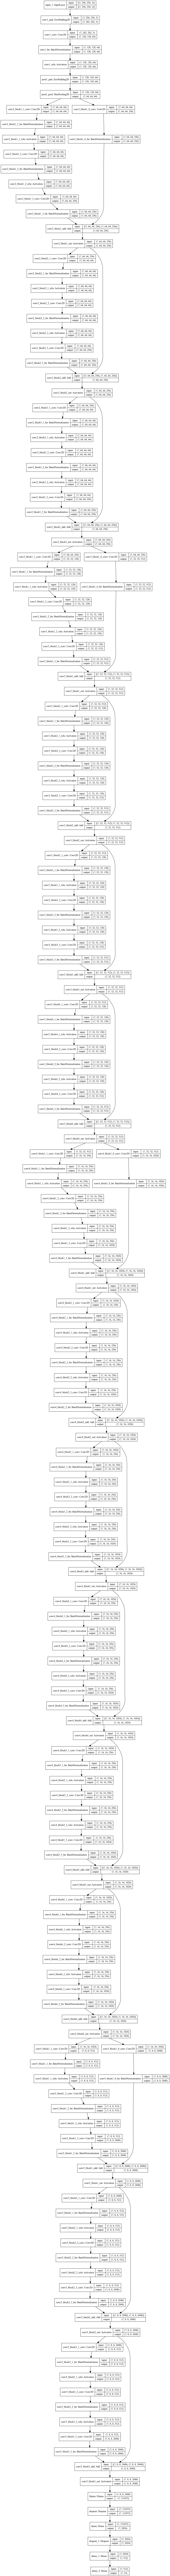

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='Plots/resnet_model_plot.png', show_shapes=True, show_layer_names=True)

Text(0.5, 1.0, 'Loss Curves')

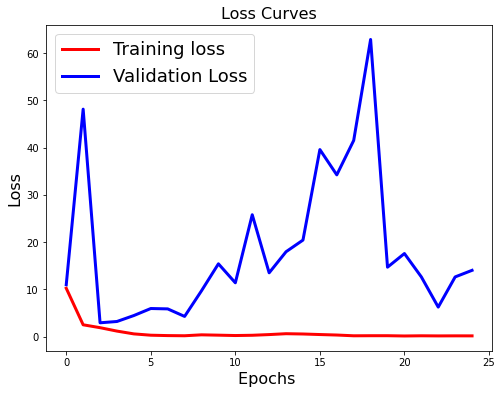

In [21]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves')

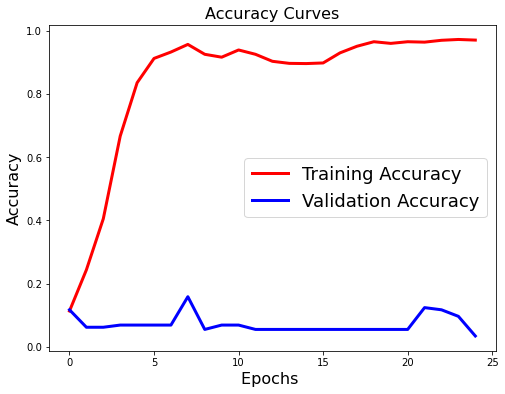

In [22]:
plt.figure(figsize=[8,6])
plt.plot(history.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)